# Inferring luminosity from a magnitude limited parallax survey

This tutorial show how to infer the luminosity for a single class of stars for which apparent magnitudes and parallaxes have been measured in a magnitude limited survey.

The survey is simulated as expained in the [notebook on simulated parallax surveys](Parallax_survey_simulation.ipynb):

* The stars are distributed uniformly (with constant space density) around the observer, between lower and upper distance limits $r_\mathrm{L}$ and $r_\mathrm{H}$.
* The stars belong to a single luminosity class and they are distributed in absolute magnitude as ${\cal N}(M\mid \mu_M, \sigma_M)$.
* A random set of (true) distances $\{r_k\}$ and true absolute magnitudes $\{M_k\}$ is generated, as well as the corresponding observed parallaxes $\{\varpi_k\}$ and observed apparent magnitudes $\{m_k\}$ (i.e. the data $D$).
* The observed quantities are generated according to a model in which the errors vary as a function of the apparent magnitude of the source.
* The survey is is limited to observed apparent magnitudes $m\leq m_\mathrm{lim}$. Setting $m_\mathrm{lim}=\infty$ in the survey simulation below will result in a _volume complete_ survey.

In a realistic case this would correspond to pre-selecting a class of stars based on other information (such as astrophysical parameters or colours) and ensuring that they are nearby (a solar neighbourhood sample) or confined to a relatively small region in 3D space so that the assumption of uniform density is a good approximation. In this example the effects of extinction are ignored.

The goal is to infer the mean absolute magnitude $\mu_M$ of the stars in the sample as well as the instrinsic spread $\sigma_M$ around this value (where for example a low instrisic spread would make this class of stars interesting as standard candles). The modelling of this problem is illustrated in the following probabilistic graphical model:

<img src="./pgm/pgm_luminosity_inference_distprior.png", width=500px/>
Dependencies between the observed data and the model parameters. Observed data is indicated by the shaded circles and model parameters by the open circles. The black dots indicate fixed parameters (for a more complex version of this model, including extinction, a different distance prior, and a contaminating population, see [Hawkins et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017MNRAS.471..722H/abstract)). 

### Volume complete case

If the survey is known to be volume complete ($m_\mathrm{lim}=+\infty$), the model of the observations consists of the following:

* The stars are assumed to belong to a single class with absolute magnitudes normally distributed around the mean $\mu_M$ with standard deviation $\sigma_M$, i.e. $M_k \sim {\cal N}(\mu_M,\sigma_M)$
* The stars are assumed to be distributed uniformly in space around the observer between (known) distance limits $r_\mathrm{L}$ and $r_\mathrm{H}$, i.e. $r_k \sim r_k^\alpha$, with $\alpha=2$, i.e. $p(r_k) = 3r_k^2/A$, with $A=r_\mathrm{H}^3-r_\mathrm{L}^3$. The space distribution is fixed here, but one could introduce $r_\mathrm{L}$, $r_\mathrm{H}$, and $\alpha$ as additional model parameters.
* The observed parallaxes are normally distributed around $\varpi_{\mathrm{true},k}=1000/r_k$ (distance in pc and parallax in mas) with a standard deviation that varies with the apparent magnitude of the star: $\varpi_k \sim {\cal N}(\varpi_{\mathrm{true},k}, \sigma_{\varpi,k})$.
* The observed apparent magnitudes are normally distributed around the true apparent magnitude with a standard deviation that varies with the apparent magnitude of the star: $m_k \sim {\cal N}(m_{\mathrm{true},k},\sigma_{m,k})$, where $m_{\mathrm{true},k} = M_k + 5\log_{10}r_k - 5$.

This leads to the following joint posterior distribution for $\mu_M$, $\sigma_M$, _and_ $\boldsymbol{r} = \{r_k\}$, and $\boldsymbol{M}=\{M_k\}$

\begin{multline}
    p(\mu_M, \sigma_M, \boldsymbol{r}, \boldsymbol{M} \mid  D) = p(\mu_M) p(\sigma_M) p(D\mid \boldsymbol{r}, \boldsymbol{M}) p(\boldsymbol{r}, \boldsymbol{M}\mid \mu_M,\sigma_M) \\ \propto
    p(\mu_M) p(\sigma_M) \times \prod_k 
    {\cal N}(\varpi_k\mid \varpi_{\mathrm{true},k}, \sigma_{\varpi,k}) \times
    {\cal N}(m_k\mid m_{\mathrm{true},k}, \sigma_{m,k}) \times
    \dfrac{3r_k^2}{A} \times
    {\cal N}(M_k\mid \mu_M,\sigma_M) \,.
\end{multline}

In this posterior the first two terms in the product over $k$ are the likelihood of the observed parallaxes and apparent magnitudes, while the third and fourth term are the priors on the distances and absolute magnitudes of the stars. The two terms outside the product over $k$ are so-called hyper-priors on the values of $\mu_M$ and $\sigma_M$. The hyper-priors have the following form

\begin{equation}
    \mu_M \sim {\cal N}(5.5,10.5) \quad\text{and}\quad
    \sigma_M \sim \begin{cases}
        {\cal N}(0,2) & \sigma_M>0 \\
        0 & \sigma_M\leq0
    \end{cases}
\end{equation}

that is a broad normal distribution for $\mu_M$ (roughly allowing for values of the mean absolute magnitude between $-5$ and $+16$), and a normal distribution truncated below $0$ for $\sigma_M$. These were chosen following these [recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) on the [Stan](http://mc-stan.org/) web-pages.

### Magnitude limited case

For the magnitude limited case we have to account for the fact that $m \leq m_\mathrm{lim}$ and this can be done by multiplying the posterior above with the selection function ${\cal S}$ which assigns a probability to the observation of a star being reported in the survey results ([see for example Palmer et al. 2014](https://ui.adsabs.harvard.edu/#abs/2014A&A...564A..49P/abstract)). In this case ${\cal S}$ is a simple step function in $m$:

\begin{equation}
    {\cal S}(m) = \begin{cases}
        1 & m\leq m_\mathrm{lim}\\
        0 & m>m_\mathrm{lim}
    \end{cases}\,,
\end{equation}

which can also be written as the Heaviside function of $(m_\mathrm{lim}-m)$, $H(m_\mathrm{lim}-m)$. Now, the selection function represents _probabilities_ and is not itself a probability density. This means that the modified posterior must be normalized in order for it to remain a probability density. This requires normalizing the product of likelihood and prior (which should be normalized as it represents the joint distribution of the data and the model parameters). The normalization constant $\cal C$ is

\begin{equation}
    {\cal C} = \int p(\mu_M) p(\sigma_M) p(D\mid \boldsymbol{r}, \boldsymbol{M}) p(\boldsymbol{r},
    \boldsymbol{M}\mid \mu_M,\sigma_M){\cal S}(\boldsymbol{m}) \,d\mu_M\,d\sigma_M\,d\boldsymbol{r}\,d\boldsymbol{M}\,dD\,.
\end{equation}

Note that the integral is over the data and all the model parameters. From the mathematical form above it is clear that the distributions over $\mu_M$, $\sigma_M$, and $\varpi$ can be integrated out first, leaving

\begin{align}
    {\cal C}  & = \int \prod_k 
    {\cal N}(m_k\mid m_{\mathrm{true},k}, \sigma_{m,k}) {\cal S}(m_k) \times
    \frac{3r_k^2}{A} \times
    {\cal N}(M_k\mid \mu_M,\sigma_M)\,d\boldsymbol{r}\,d\boldsymbol{M}\,d\boldsymbol{m}\\
    & = \prod_k \int_{r_\mathrm{L}}^{r_\mathrm{H}} \int_{-\infty}^{+\infty} 
    \int_{-\infty}^{m_\mathrm{lim}} {\cal N}(m_k\mid m_{\mathrm{true},k}, \sigma_{m,k})\,dm_k
    \frac{3r_k^2}{A}
    {\cal N}(M_k\mid \mu_M,\sigma_M)\,dM_k\,dr_k \\
    & = \prod_k {\cal C}_k \,,
\end{align}

where one should keep in mind that $m_{\mathrm{true},k}$ introduces a relation between $r_k$ and $M_k$. Focusing on one factor ${\cal C}_k$ we can write the integral as

\begin{equation}
    {\cal C}_k = \int_{r_\mathrm{L}}^{r_\mathrm{H}} \int_{-\infty}^{+\infty}
    \Phi\left(\dfrac{m_\mathrm{lim}-(M_k+5\log_{10}r_k-5)}{\sigma_{m,k}}\right)
    \frac{3r_k^2}{A}
    {\cal N}(M_k\mid \mu_M,\sigma_M)\,dM_k\,dr_k\,,
\end{equation}

where $\Phi(t)$ is the cumulative standard normal distribution

\begin{equation}
    \Phi(t) = \int_{-\infty}^t
    \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2} \,dz = 
    \frac{1}{2} \left(1 + \mathrm{erf}\left( \frac{t}{\sqrt{2}} \right)\right)\,.
\end{equation}

The normalization constant has the effect of increasing (for a given magnitude limit) the posterior probabilities of faint values of $\mu_M$ with respect to bright values. This is what is needed to 'compensate' for the fact that the survey contains a bright sample of the full population of stars. The notebook on [handling data truncation](Handling_Data_Truncation.ipynb) works through a simplified example that illustrates this point.

The integral above can be calculated numerically but we can take a practical shortcut to make the integral easier to calculate. In most surveys the magnitude errors are relatively small, such that

\begin{equation}
    \Phi\left(\dfrac{m_\mathrm{lim}-(M_k+5\log_{10}r_k-5)}{\sigma_{m,k}}\right) \approx
    H\left(m_\mathrm{lim}-(M_k+5\log_{10}r_k-5)\right)\,,
\end{equation}

which introduces a step function cut-off at $m_\mathrm{lim}$ in the distribution of the true apparent magnitudes (while we know the cut-off in $m_\mathrm{true}$ is 'fuzzy' in reality). The integral ${\cal C}_k$ then reduces to

\begin{equation}
    {\cal C}_k = \int_{r_\mathrm{L}}^{r_\mathrm{H}} \int_{-\infty}^{m_\mathrm{lim}-5\log_{10}r_k+5}
    \frac{3r_k^2}{A}
    {\cal N}(M_k\mid \mu_M,\sigma_M)\,dM_k\,dr_k =
    \int_{r_\mathrm{L}}^{r_\mathrm{H}} \frac{3r_k^2}{A}
    \Phi\left(\frac{m_\mathrm{lim}-(\mu_M+5\log_{10}r-5)}{\sigma_M}\right)\,dr_k\,.
\end{equation}

The numerical quadrature will now involve a 1D integral which is easier to implement, but keep in mind that the resulting posterior is only approximately correct in that we ignore the fact that some stars in the survey will actually have $m_\mathrm{true}>m_\mathrm{lim}$.

### Sampling the posterior

Note that the posterior is a distribution over not only the parameters of interest ($\mu_M$ and $\sigma_M$) but also over the distances and absolute magnitudes of the individual stars. The latter set of parameters are considered 'nuisance parameters' (we are not interested in them) and ideally should be integrated out of the posterior. This cannot be done analytically in this case but the Markov-Chain Monte-Carlo method does allow to carry out the integration numerically, by sampling the posterior over $\mu_M$, $\sigma_M$, $\boldsymbol{r}$, and $\boldsymbol{M}$, and then examining only the samples for $\mu_M$ and $\sigma_M$. The distributions of the latter will properly account for the uncertainties in $\boldsymbol{r}$ and $\boldsymbol{M}$ caused by observational errors.

The code blocks below implement the above problem in Python, using the [Python interface](http://mc-stan.org/users/interfaces/pystan.html) to the [Stan](http://mc-stan.org/) statistical modelling package. The Stan model code for this example is contained in [luminosity_inference_distance_prior.stan](luminosity_inference_distance_prior.stan) (magnitrude limited case) and [luminosity_inference_volume_complete_distance_prior.stan](luminosity_inference_volume_complete_distance_prior.stan) (for the volume complete case).

The code below can also be executed from the command line through the [luminosity_inference_distance_prior.py](luminosity_inference_distance_prior.py) programme. This provides more output on the console concerning the progress of the MCMC sampler. When experimenting with a volume-complete survey it makes sense to invoke the switch `--volumecomplete`. This results in using the Stan model specialized for the volume-complete case, which runs faster.

## Python imports

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
import corner
from stantools import load_stan_code, stan_cache

from parallaxsurveys import UniformDistributionSingleLuminosityHip as udslH
from parallaxsurveys import UniformDistributionSingleLuminosityTGAS as udslT
from parallaxsurveys import showSurveyStatistics

from plotstyles import useagab, apply_tufte

## Simulating the survey

The code block below simulates the survey, in this case a survey with observational errors according to a Hipparcos error model. The default survey parameters have been chosen to illustrate that parallaxes with large relative errors and negative parallaxes can be used without any problem in the Bayesian luminosity inference setting.

The resulting survey statistics are shown to provide some insight into the survey properties and biases that would result from selecting 'good' parallaxes. The upper left panel shows the true and observed parallax distribution alongside the model distribution. Note the substantial number of negative parallaxes among the observations.

The lower left panel shows how the absolute magnitude distribution gets biased when selecting only stars with 'good' parallaxes.

The bottom right panel shows the difference between the estimate $\widetilde{M}$ of the absolute magnitudes of the individual stars, obtained simply as $\widetilde{M}=m+5\log_{10}(\varpi)-10$, and the true absolute magnitude as a function of the relative parallax error. The vertical line shows the limit $\sigma_\varpi/\varpi\leq 0.175$

The model distribution for $m_\mathrm{true}$ (upper right panel) can be derived analytically, see the [notebook on simulated parallax surveys](Parallax_survey_simulation.ipynb).

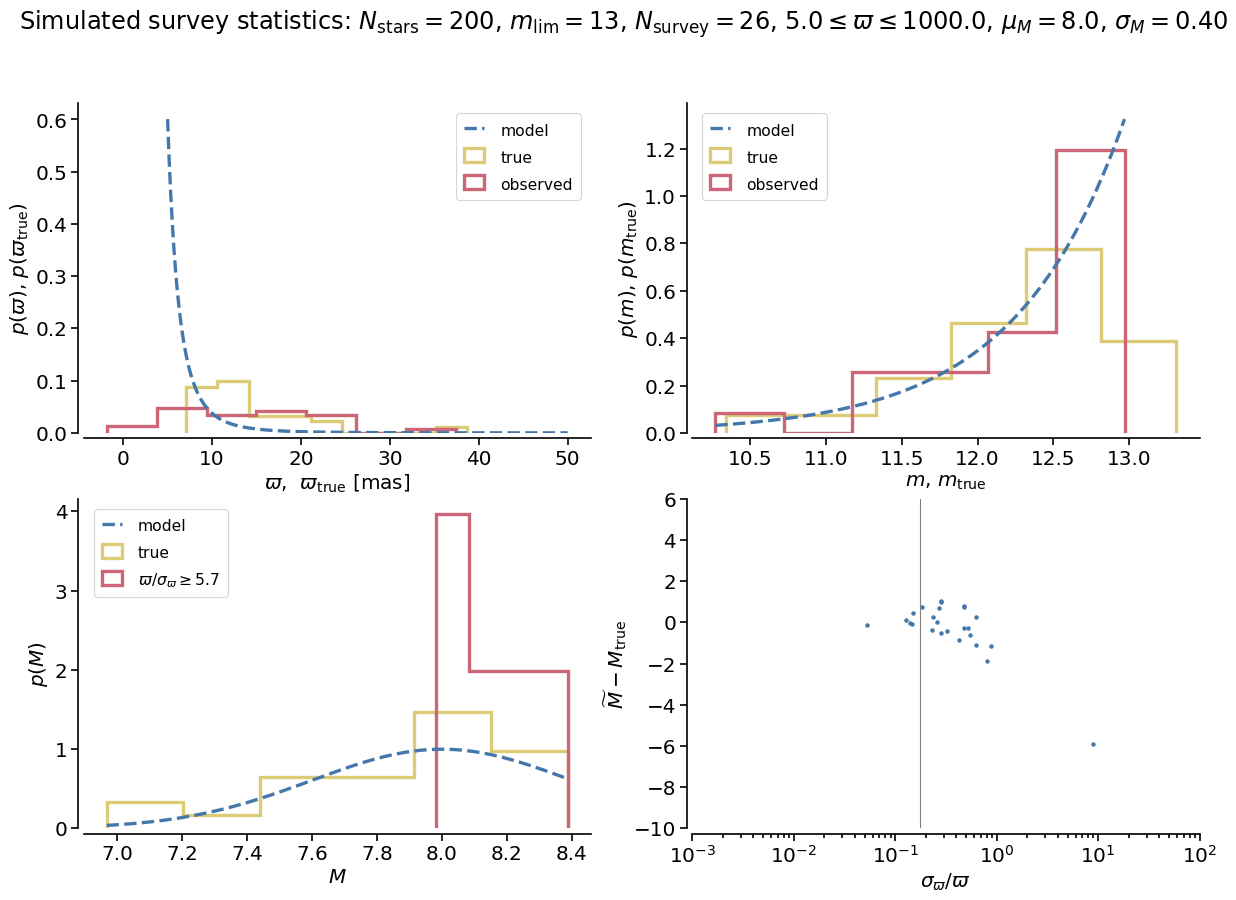

In [2]:
distMin = 1.0
distMax = 200.0
nStars = 200
meanAbsMagTrue = 8.0
sigmaAbsMagTrue = 0.4
surveyseed = None
mlim = 13

# For TGAS simulation use udslT
survey = udslH(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=mlim)
survey.setRandomNumberSeed(surveyseed)
survey.generateObservations()
showSurveyStatistics(survey, usekde=False)

## Naive estimate of the mean absolute magnitude, including Lutz-Kelker correction

The next code block implements a naive estimate of $\mu_M$ which is obtained by selecting stars with 'good' parallaxes in this case $\varpi/\sigma_\varpi>(0.175)^{-1}$, where the limit on the relative error ($0.175$) is taken from the [Lutz & Kelker paper](http://adsabs.harvard.edu/abs/1973PASP...85..573L). For each star the absolute magntude is calculated as $m+5\log_{10}\varpi-10$ and then corrected according to table 3 in that paper. The resulting mean and standard deviation of the uncorrected and corrected absolute magnitude estimates are reported.

Note that the naive estimate for the mean is often quite good, which is because the Lutz-Kelker correction was designed exactly for this problem (although assuming no magnitude limit and a fixed relative parallax error).

In [3]:
lk_correction = interp1d(np.linspace(0,0.175,8), 
                         np.array([0.0, -0.01, -0.02, -0.06, -0.11, -0.18,-0.28, -0.43]), kind='quadratic')
lk_relative_error_limit = 0.175
goodplx = np.where(survey.observedParallaxes/survey.parallaxErrors >= 1/lk_relative_error_limit)

if goodplx[0].size>=3:
    absMagNaive = survey.observedMagnitudes[goodplx] + 5*np.log10(survey.observedParallaxes[goodplx]) - 10.0
    absMagNaiveCorrected = absMagNaive + \
        lk_correction(survey.parallaxErrors[goodplx]/survey.observedParallaxes[goodplx])
    print("Number of 'good' parallaxes used {0}/{1}".format(survey.observedParallaxes[goodplx].size, 
                                                            survey.observedParallaxes.size))
    print("### Naive estimate ###")
    print("Mean and sigma: {0:.2f}, {1:.2f}".format(absMagNaive.mean(), absMagNaive.std()))                                                               
    print("### Naive estimate after LK correction ###")
    print("Mean and sigma: {0:.2f}, {1:.2f}".format(absMagNaiveCorrected.mean(), absMagNaiveCorrected.std()))
else:
    print("Cannot make naive estimate")

Number of 'good' parallaxes used 5/26
### Naive estimate ###
Mean and sigma: 8.22, 0.19
### Naive estimate after LK correction ###
Mean and sigma: 8.03, 0.18


## Sampling the posterior to obtain an estimate of the mean absolute magnitude

The following code block shows how PyStan can be used to sample the posterior distribution above and obtain an estimate for $\mu_M$ and $\sigma_M$. Note in particular that all stars in the sample can be used, regardless of their relative parallax error. If the survey limit above is $+\infty$ the Stan code loaded is specialized for volume complete surveys and runs faster.

Using cached StanModel
Inference for Stan model: anon_model_8c97174f425dbf1d8bdcf913045466c4.
4 chains, each with iter=100000; warmup=50000; thin=5; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanAbsMag    8.32    0.26   0.58   7.81   7.98   8.11   8.39  10.36      5   1.51
sigmaAbsMag   0.46    0.18   0.36   0.05   0.18   0.35   0.64   1.42      4   1.71
lp__        -45.35    8.99   20.1 -78.64 -61.28 -46.89 -31.79   -1.0      5   1.46

Samples were drawn using NUTS at Sun Jan 14 18:33:11 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


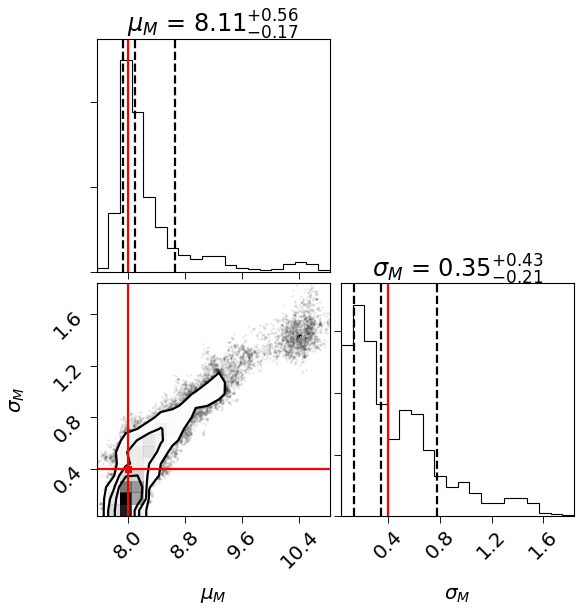

In [6]:
stanseed = None
numChains = 4

if (not np.isinf(mlim)):
    # For the magnitude limited case, explicit initialization of the true absolute magnitudes is
    # needed. See comments in Stan code.
    initUp = min(survey.apparentMagnitudeLimit-5*np.log10(distMax)+5, 2)
    initLow = initUp - 4
    initialValuesList = []
    for i in range(numChains):
        initialValuesList.append( dict(absMag=np.random.uniform(initLow, initUp, 
                                                                size=survey.numberOfStarsInSurvey)) )

    stan_data = {'minDist':distMin, 'maxDist':distMax, 'N':survey.numberOfStarsInSurvey,
                 'surveyLimit':survey.apparentMagnitudeLimit,
                 'obsPlx':survey.observedParallaxes, 'errObsPlx':survey.parallaxErrors,
                 'obsMag':survey.observedMagnitudes, 'errObsMag':survey.magnitudeErrors}
    stanmodel = load_stan_code("luminosity_inference_distance_prior.stan")
    sm = stan_cache(stanmodel, model_name="luminosityInferenceDistPrior")
    # Magnitude limited case requires many more iterations
    fit = sm.sampling(data = stan_data, pars=['meanAbsMag', 'sigmaAbsMag'], iter=100000, 
                      chains=numChains, thin=5, seed=stanseed, init=initialValuesList)    
else:
    # Volume complete case
    stan_data = {'minDist':distMin, 'maxDist':distMax, 'N':survey.numberOfStarsInSurvey,
                 'obsPlx':survey.observedParallaxes, 'errObsPlx':survey.parallaxErrors,
                 'obsMag':survey.observedMagnitudes, 'errObsMag':survey.magnitudeErrors}
    stanmodel = load_stan_code("luminosity_inference_volume_complete_distance_prior.stan")
    sm = stan_cache(stanmodel, model_name="luminosityInferenceDistPriorVC")
    fit = sm.sampling(data = stan_data, pars=['meanAbsMag', 'sigmaAbsMag'], iter=10000, 
                      chains=numChains, thin=5, seed=stanseed)    

print(fit)

samples = np.vstack([fit.extract()['meanAbsMag'], fit.extract()['sigmaAbsMag']]).transpose()
    
fig = plt.figure(figsize=(8,8))
for i in range(1,5):
    fig.add_subplot(2,2,i)
corner.corner(samples, labels=[r'$\mu_M$', r'$\sigma_M$'], truths=[meanAbsMagTrue, sigmaAbsMagTrue],
              truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=fig)
plt.show()

## Checking the model

After the inference step through MCMC it is good to check whether our model is actually a good fit to the data. One way to do this is by checking whether the model (given the parameters inferred) is consistent with the data. This can be done by predicting the the distribution of the observations using the model (see chapter 6 in [Gelman et al. 2016](https://www.crcpress.com/Bayesian-Data-Analysis-Third-Edition/Gelman-Carlin-Stern-Dunson-Vehtari-Rubin/p/book/9781439840955)). The code block below takes the MCMC samples of $\mu_M$ and $\sigma_M$ and runs a survey simulation for each of those and then compares the resulting simulated $m$ and $\varpi$ distributions with the actually observed ones. A good model fit should lead to simulated data that look like the actual observations.

Note that a good model fit in the sense above is not sufficient to state that one has somehow uncovered the 'truth'. One can only state that the model considered explains the data, but the model may still differ from the truth. Gross differences between predicted and observed data do point to problems with the model.

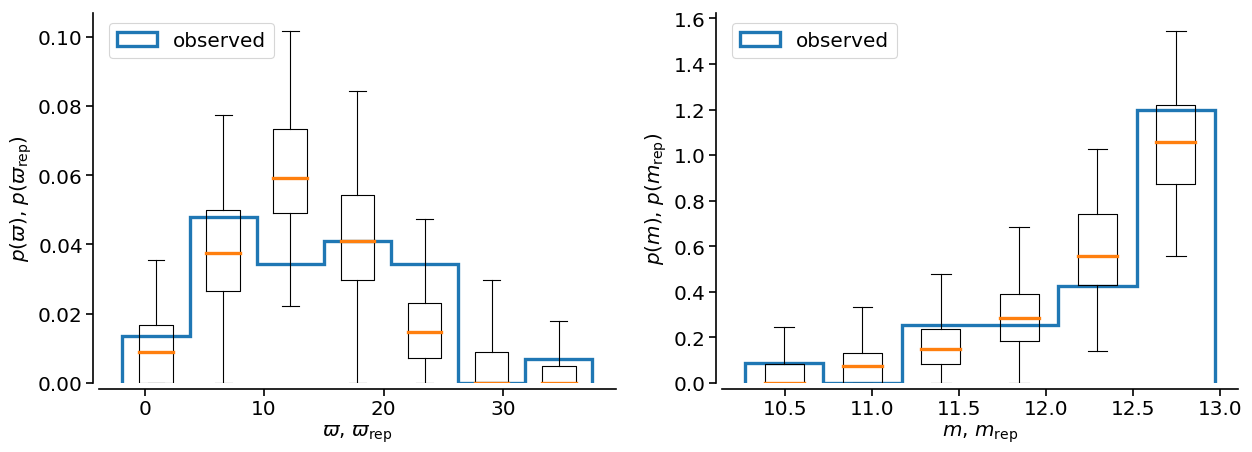

In [7]:
musamples = fit.extract()['meanAbsMag']
sigmasamples = fit.extract()['sigmaAbsMag']

v, plxbins = np.histogram(survey.observedParallaxes, bins='auto', normed=True)
v, magbins = np.histogram(survey.observedMagnitudes, bins='auto', normed=True)


ransamples = np.random.choice(np.arange(musamples.size), size=1000, replace=False)
replicated_survey = udslH(nStars, distMin, distMax, musamples[ransamples[0]], sigmasamples[ransamples[0]],
                          surveyLimit=mlim)
replicated_survey.generateObservations()
v, b = np.histogram(replicated_survey.observedParallaxes, bins=plxbins, normed=True)
rep_plxs = v
v, b = np.histogram(replicated_survey.observedMagnitudes, bins=magbins, normed=True)
rep_mags = v

for i in ransamples[1:]:
    replicated_survey = udslH(nStars, distMin, distMax, musamples[i], sigmasamples[i], surveyLimit=mlim)
    replicated_survey.generateObservations()
    v, b = np.histogram(replicated_survey.observedParallaxes, bins=plxbins, normed=True)
    rep_plxs = np.vstack((rep_plxs, v))
    v, b = np.histogram(replicated_survey.observedMagnitudes, bins=magbins, normed=True)
    rep_mags = np.vstack((rep_mags, v))

useagab(usetex=False, fontfam='sans', sroncolours=False)
fig, (axA, axB) = plt.subplots(1,2,figsize=(16,6))

apply_tufte(axA)
axA.hist(survey.observedParallaxes, bins='auto', normed=True, histtype='step', lw=3, label='observed')
axA.boxplot(rep_plxs, positions=0.5*(plxbins[1:]-plxbins[:-1])+plxbins[:-1], whis=[2.5,97.5], 
            showfliers=False, manage_xticks=False, widths=0.5*(plxbins[1]-plxbins[0]), 
            medianprops={'linewidth':3})
axA.set_xlabel(r'$\varpi$, $\varpi_\mathrm{rep}$')
axA.set_ylabel(r'$p(\varpi)$, $p(\varpi_\mathrm{rep})$')
axA.legend(loc='upper left')

apply_tufte(axB)
axB.hist(survey.observedMagnitudes, bins='auto', normed=True, histtype='step', lw=3, label='observed')
axB.boxplot(rep_mags, positions=0.5*(magbins[1:]-magbins[:-1])+magbins[:-1], whis=[2.5,97.5], 
            showfliers=False, manage_xticks=False, widths=0.5*(magbins[1]-magbins[0]), 
            medianprops={'linewidth':3})
axB.set_xlabel(r'$m$, $m_\mathrm{rep}$')
axB.set_ylabel(r'$p(m)$, $p(m_\mathrm{rep})$')
axB.legend(loc='upper left')

plt.tight_layout()
plt.show()